### **Resumo do Experimento #Final: Comparativo com PSPNet**

* **Objetivo:** Comparar o desempenho da arquitetura PSPNet com os modelos anteriores (U-Net, DeepLabv3), mantendo todos os demais hiperparâmetros constantes para uma avaliação justa.

* **Arquitetura do Modelo:**
    * **PSPNet** com backbone **ResNet-101 pré-treinado** no dataset COCO.

* **Configuração do Treinamento:**
    * **Função de Perda:** Dice + BCE Loss (`DiceBCELoss`)
    * **Otimizador:** Adam
    * **Taxa de Aprendizado Inicial:** `1e-4`
    * **Batch Size:** `4`
    * **Número Máximo de Épocas:** `100`

* **Agendador de Taxa de Aprendizado (Scheduler):**
    * **Estratégia:** `ReduceLROnPlateau`
    * **Métrica Monitorada:** `Validation IoU`
    * **Paciência:** `5` épocas
    * **Fator de Redução:** `0.2`

In [5]:
# CELULA 1
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures
import csv
import pandas as pd
import seaborn as sns

In [6]:
# CELULA 2
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [7]:
# CELULA 3
# --- Configurações do Ambiente e Caminhos ---
# Certifique-se de que este caminho aponta para os dados pré-processados
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" 
MODEL_SAVE_PATH = "./pspnet_best.pth"
CSV_LOG_PATH = "./pspnet_training_log.csv"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# --- Hiperparâmetros para o Treinamento v2 ---
config = {
    "LEARNING_RATE": 1e-4,       # LR inicial. O scheduler vai ajustá-lo.
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 100,            
    "IMAGE_HEIGHT": 256,
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam",
    "LOSS_FUNCTION": "DiceBCE"
}

# NOVO: Configuração do Agendador de Taxa de Aprendizado (Scheduler)
scheduler_config = {
    "factor": 0.2,               # Fator de redução do LR (new_lr = lr * factor). 0.1 ou 0.2 são comuns.
    "patience": 5,               # Nº de épocas sem melhora no val_iou para reduzir o LR.
    "min_lr": 1e-7,              # Taxa de aprendizado mínima.
    "verbose": True              # Imprime uma mensagem quando o LR é atualizado.
}

Usando o dispositivo: cuda


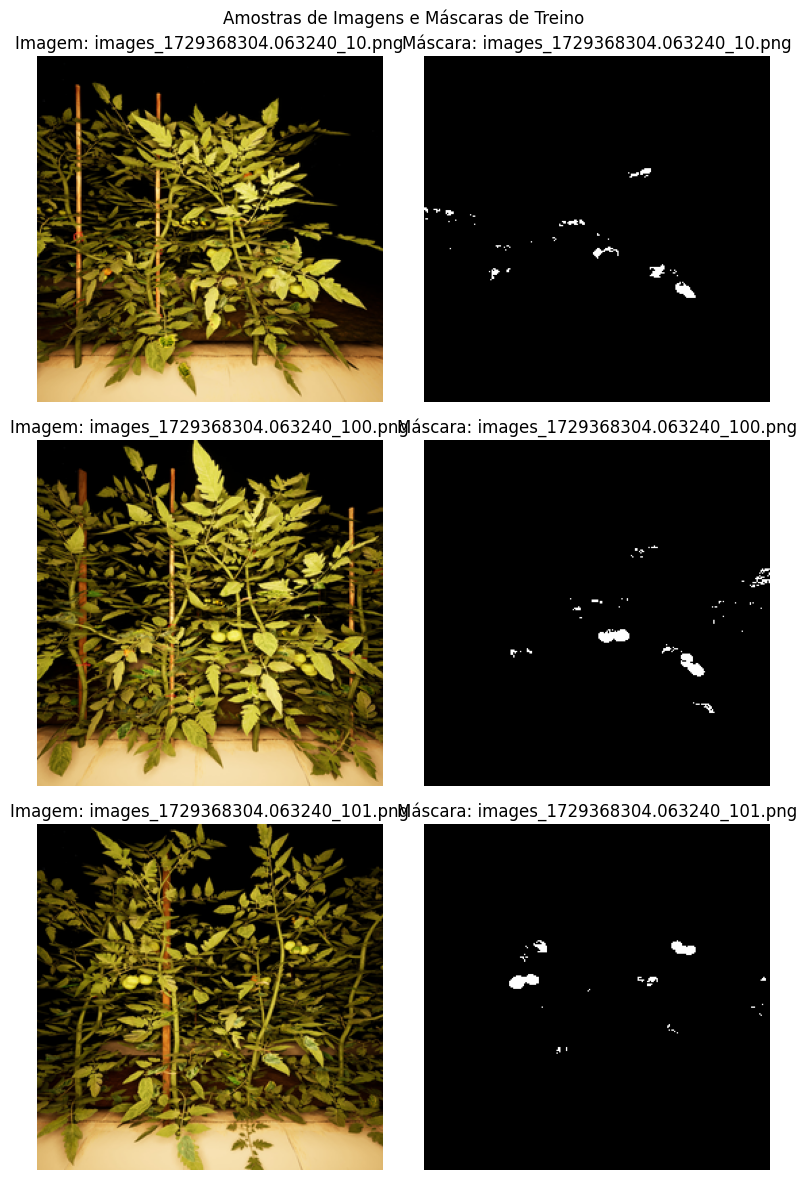

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 1854.43it/s]


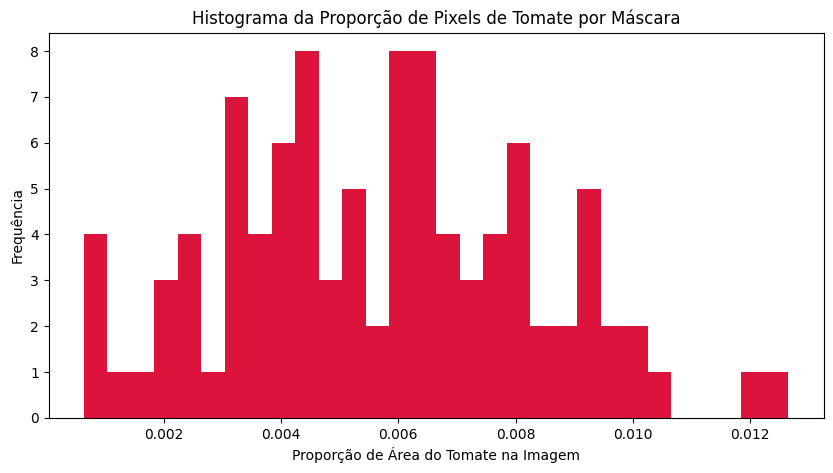

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [8]:
# CELULA 4
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [9]:
# CELULA 5
# Classe customizada para carregar os dados
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Tratar extensões diferentes entre imagem e máscara
        mask_name = img_name
        possible_mask_exts = ['.png', '.jpg', '.jpeg']
        for ext in possible_mask_exts:
            if mask_name.endswith(ext):
                base_name = mask_name[:-len(ext)]
                break
        else:
            base_name = mask_name

        mask_path = None
        for ext in possible_mask_exts:
            potential_path = os.path.join(self.mask_dir, base_name + ext)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            # Tenta com o mesmo nome exato se falhar
             mask_path = os.path.join(self.mask_dir, img_name)
             if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem {img_name}")


        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalizar máscara para 0.0-1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Definir transformações (redimensionamento e conversão para tensor)
# Para data augmentation, pode-se usar a biblioteca Albumentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# Por simplicidade, usaremos torchvision transforms
NUM_WORKERS = 0 # <<<< COMECE COM ESTE VALOR

# --- Transformações ---
# Como você já pré-processou, não precisamos mais do Resize
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


class CustomTomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        # Pega a lista de imagens e cria uma referência para as máscaras
        self.image_files = sorted(os.listdir(image_dir))
        
        # Verificação inicial: Checa se pelo menos a primeira máscara existe
        if len(self.image_files) > 0:
            self._verify_path(0)

    def __len__(self):
        return len(self.image_files)

    def _verify_path(self, index):
        """Função interna para encontrar o caminho correto da máscara."""
        img_name = self.image_files[index]
        base_name, _ = os.path.splitext(img_name)
        
        # Tenta as extensões mais comuns para máscaras
        possible_mask_names = [f"{base_name}.png", f"{base_name}.jpg", f"{base_name}.jpeg"]
        
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(mask_path):
                return mask_path
        
        # Se não encontrar, levanta um erro claro
        raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem '{img_name}'. "
                              f"Procurado por {possible_mask_names} na pasta {self.mask_dir}")

    def __getitem__(self, index):
        try:
            # Caminho da imagem
            img_path = os.path.join(self.image_dir, self.image_files[index])
            
            # Caminho da máscara (verificado pela função interna)
            mask_path = self._verify_path(index)
            
            # Carregar imagem e máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Aplicar transformações
            image = self.img_transform(image)
            mask = self.mask_transform(mask)
            
            # Binarizar a máscara para garantir 0s e 1s
            mask = (mask > 0.5).float()
            
            return image, mask

        except Exception as e:
            print(f"Erro ao carregar o item no índice {index}, arquivo: {self.image_files[index]}")
            # Retornar o erro para que o DataLoader possa lidar com ele (ou pular o item)
            raise e


# Criar Datasets
try:
    # ATENÇÃO: Verifique se o DATA_DIR está apontando para a pasta pré-processada (ex: .../processed_data_256)
    train_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    val_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset de treino: {len(train_ds)} amostras.")
    print(f"Dataset de validação: {len(val_ds)} amostras.")
    print(f"DataLoader usando {NUM_WORKERS} workers.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

print(f"Dataset de treino: {len(train_ds)} amostras.")
print(f"Dataset de validação: {len(val_ds)} amostras.")

Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.
DataLoader usando 0 workers.
Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.


In [10]:
# ===================================================================
# CÉLULA 6: DEFINIÇÃO DA FUNÇÃO DE PERDA (SUBSTITUIR)
# ===================================================================

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Aplicar sigmoid para ter probabilidades
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat = inputs_sig.view(-1)
        targets_flat = targets.view(-1)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        
        bce = nn.BCEWithLogitsLoss()(inputs, targets)
        
        return bce + dice_loss

# Instancia a função de perda para ser usada no treinamento
loss_fn = DiceBCELoss()

print("Classe 'DiceBCELoss' e variável 'loss_fn' definidas e prontas.")

Classe 'DiceBCELoss' e variável 'loss_fn' definidas e prontas.


In [11]:
# ===================================================================
# CÉLULA 7: DEFINIÇÃO DO MODELO PSPNET (VERSÃO FINAL E CORRETA)
# ===================================================================
import torch
import segmentation_models_pytorch as smp

def get_pspnet_model(num_classes):
    model = smp.PSPNet(
        encoder_name="resnet34",        # ou "resnet50", "efficientnet-b0" etc.
        encoder_weights="imagenet",
        classes=num_classes,
        activation=None
    )
    return model


# --- Instancia o modelo para o treinamento ---
model = get_pspnet_model(num_classes=1).to(DEVICE)

# Teste rápido para verificar as dimensões da saída
try:
    x = torch.randn(2, 3, 256, 256).to(DEVICE)
    output = model(x)
    assert output['out'].shape == (2, 1, 256, 256)
    print("Arquitetura PSPNet carregada (via torch.hub) e adaptada com sucesso!")
except Exception as e:
    print(f"Ocorreu um erro ao testar a arquitetura: {e}")

Ocorreu um erro ao testar a arquitetura: new(): invalid data type 'str'


In [12]:
# ===================================================================
# CÉLULA 8: FUNÇÃO 'train_fn' CORRIGIDA (SUBSTITUIR)
# ===================================================================
def train_fn(loader, model, optimizer, loss_fn, scaler):
    """
    Executa o loop de treinamento para uma única época.
    """
    loop = tqdm(loader, desc="Training")
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            # CORREÇÃO: A PSPNet carregada retorna o tensor diretamente
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

print("Função 'train_fn' (corrigida para PSPNet) definida e pronta.")

Função 'train_fn' (corrigida para PSPNet) definida e pronta.


In [13]:
# ===================================================================
# CÉLULA 9: FUNÇÃO DE MÉTRICAS CORRIGIDA (SUBSTITUIR)
# ===================================================================
def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    """
    Calcula as métricas de validação (IoU e Dice) para o modelo.
    """
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            # CORREÇÃO: A PSPNet carregada retorna o tensor diretamente
            preds_logits = model(x)
            preds = torch.sigmoid(preds_logits)
            preds = (preds > 0.5).float()

            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)

    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)
    
    return avg_iou, avg_dice

print("Função 'check_accuracy_and_get_metrics' (corrigida para PSPNet) definida e pronta.")

Função 'check_accuracy_and_get_metrics' (corrigida para PSPNet) definida e pronta.


In [ ]:
# ===================================================================
# CÉLULA 10: LOOP DE TREINAMENTO CORRIGIDO (SUBSTITUIR)
# ===================================================================

# --- SETUP DO OTIMIZADOR E SCHEDULER ---
# As variáveis 'model' e 'loss_fn' já foram definidas nas células anteriores.
# Apenas criamos o otimizador e o scaler para este novo modelo.
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'max',
    factor=scheduler_config["factor"],
    patience=scheduler_config["patience"],
    min_lr=scheduler_config["min_lr"],
    verbose=True
)

# --- INICIALIZAÇÃO DO LOG ---
best_val_iou = -1.0
with open(CSV_LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'val_iou', 'val_dice', 'learning_rate', 'duration_sec'])
print(f"Arquivo de log criado em: {CSV_LOG_PATH}")


# --- LOOP DE TREINAMENTO ---
print("\n--- Iniciando o Treinamento com PSPNET ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    # As funções 'train_fn' e 'check_accuracy_and_get_metrics' são chamadas aqui
    model.train()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    model.eval()
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Imprime o resumo da época
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f} | LR: {current_lr:.2e}")
    print(f"Validação -> IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

    scheduler.step(val_iou)

    # Salva os dados da época no arquivo CSV
    with open(CSV_LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, train_loss, val_iou.item(), val_dice.item(), current_lr, epoch_duration])

    # Salva o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo! **")

print("--- Treinamento Concluído ---")

In [14]:
# ===================================================================
# CÉLULA 9: FUNÇÃO DE MÉTRICAS CORRIGIDA (SUBSTITUIR)
# ===================================================================

def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    """
    Calcula as métricas de validação (IoU e Dice) para o modelo.
    """
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            preds_logits = model(x)
            preds = torch.sigmoid(preds_logits)
            preds = (preds > 0.5).float()

            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)

    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)
    
    return avg_iou, avg_dice

print("Função 'check_accuracy_and_get_metrics' (corrigida) definida e pronta.")

Função 'check_accuracy_and_get_metrics' (corrigida) definida e pronta.


Carregando o melhor modelo PSPNet salvo de './pspnet_best.pth'...
Carregando log de treinamento de './pspnet_training_log.csv'...
Gerando gráficos de treinamento...


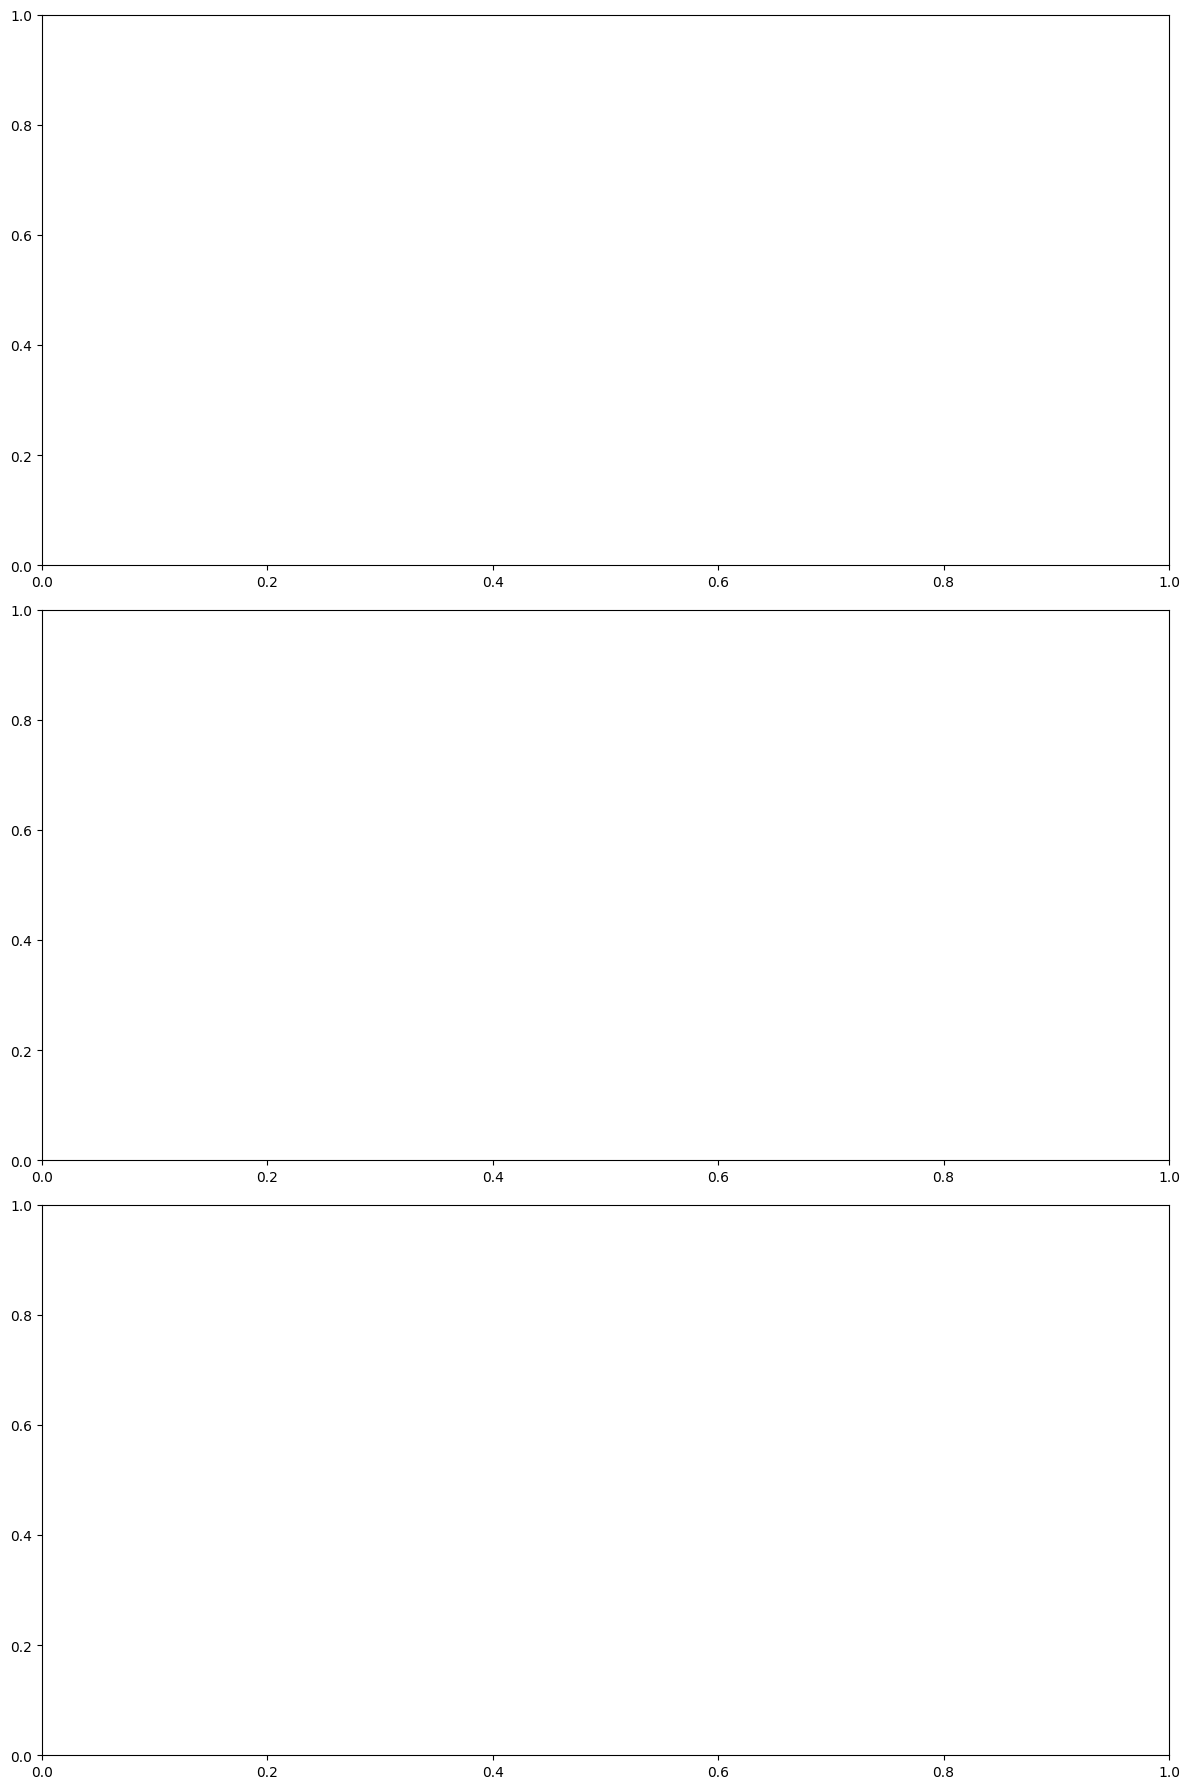


Calculando métricas finais detalhadas no conjunto de validação...


Calculando Métricas Finais: 100%|██████████| 1058/1058 [00:20<00:00, 51.34it/s]



      RESULTADOS FINAIS DO MELHOR MODELO (PSPNet)
IoU         : 0.5528
Dice/F1     : 0.7120
Precision   : 0.7351
Recall      : 0.6903

Gerando visualizações de predições do melhor modelo PSPNet...


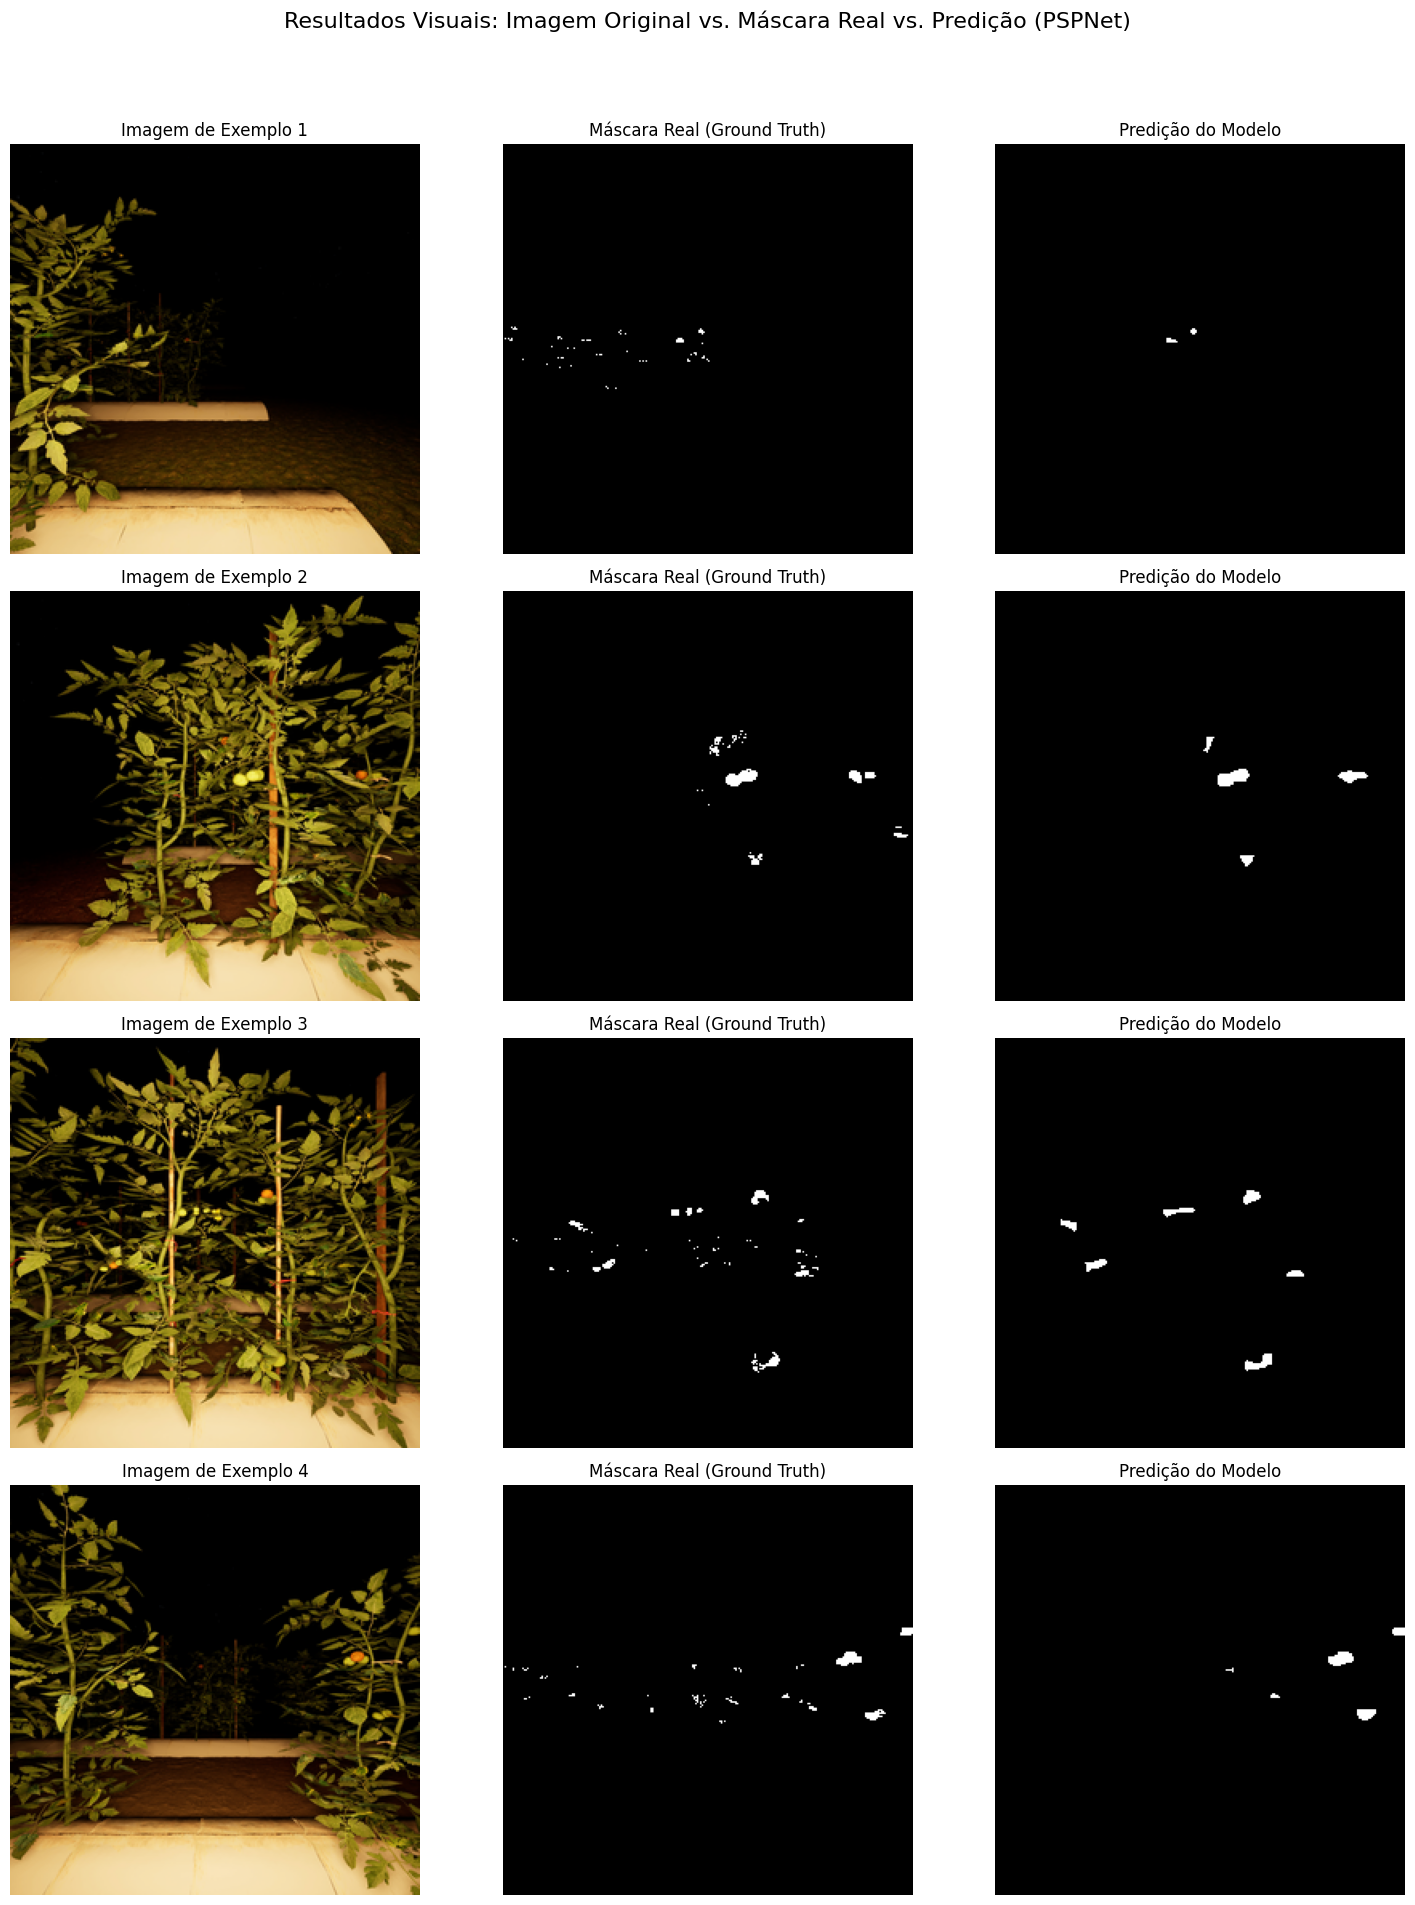

In [ ]:
# ===================================================================
# CÉLULA 11: ANÁLISE FINAL CORRIGIDA PARA PSPNET (VERSÃO AJUSTADA)
# ===================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import torch
import torch.nn.functional as F

# --- 1. CARREGAR DADOS E O MELHOR MODELO PSPNET ---
print(f"Carregando o melhor modelo PSPNet salvo de '{MODEL_SAVE_PATH}'...")
# Certifique-se que a função get_pspnet_model e as variáveis estão definidas
analysis_model = get_pspnet_model(num_classes=1).to(DEVICE)
analysis_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
analysis_model.eval()
print(f"Carregando log de treinamento de '{CSV_LOG_PATH}'...")
log_df = pd.read_csv(CSV_LOG_PATH)


# --- 2. GERAR GRÁFICOS DE TREINAMENTO ---
print("Gerando gráficos de treinamento...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
# Exemplo:
# sns.lineplot(x='epoch', y='train_loss', data=log_df, ax=ax1, label='Train Loss')
# sns.lineplot(x='epoch', y='val_iou', data=log_df, ax=ax2, label='Validation IoU')
# sns.lineplot(x='epoch', y='learning_rate', data=log_df, ax=ax3, label='Learning Rate')
# ax3.set_yscale('log')
plt.tight_layout()
plt.show()


# --- 3. CÁLCULO DE MÉTRICAS FINAIS DETALHADAS (FUNÇÃO AJUSTADA) ---
def calculate_final_metrics(loader, model, device, smooth=1e-6):
    print("\nCalculando métricas finais detalhadas no conjunto de validação...")
    model.eval()
    
    # AJUSTE 1: Acumular TP, FP, FN em todo o dataset em vez de fazer a média das métricas
    total_tp, total_fp, total_fn = 0, 0, 0

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculando Métricas Finais"):
            x, y = x.to(device), y.to(device)
            
            # Obtém a predição do modelo
            preds_logits = model(x)
            
            # AJUSTE 2: Garante que a predição tenha o mesmo tamanho da máscara real (muito importante para PSPNet)
            preds_logits = F.interpolate(preds_logits, size=y.shape[2:], mode='bilinear', align_corners=False)
            
            # Aplica Sigmoid e limiar de 0.5
            preds = torch.sigmoid(preds_logits)
            preds = (preds > 0.5).float()
            
            # Achata as predições e máscaras para calcular os totais
            preds_flat = preds.view(-1)
            y_flat = y.view(-1)
            
            # Acumula os valores de True Positives, False Positives e False Negatives
            total_tp += (preds_flat * y_flat).sum()
            total_fp += preds_flat.sum() - (preds_flat * y_flat).sum()
            total_fn += y_flat.sum() - (preds_flat * y_flat).sum()

    # AJUSTE 3: Calcula as métricas finais uma única vez com os totais acumulados
    iou = (total_tp + smooth) / (total_tp + total_fp + total_fn + smooth)
    dice = (2. * total_tp + smooth) / (2. * total_tp + total_fp + total_fn + smooth)
    precision = (total_tp + smooth) / (total_tp + total_fp + smooth)
    recall = (total_tp + smooth) / (total_tp + total_fn + smooth)

    final_metrics = {
        "IoU": iou.item(),
        "Dice/F1": dice.item(),
        "Precision": precision.item(),
        "Recall": recall.item()
    }
    return final_metrics

final_metrics = calculate_final_metrics(val_loader, analysis_model, DEVICE)


# --- 4. EXIBIR TABELA DE RESULTADOS FINAIS ---
print("\n" + "="*53)
print("      RESULTADOS FINAIS DO MELHOR MODELO (PSPNet)")
print("="*53)
for metric, value in final_metrics.items():
    print(f"{metric:<12}: {value:.4f}")
print("="*53 + "\n")


# --- 5. VISUALIZAÇÃO QUALITATIVA DAS PREDIÇÕES ---
print("Gerando visualizações de predições do melhor modelo PSPNet...")
inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
val_images, val_masks = next(iter(val_loader))
num_images = min(5, len(val_images))
fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
fig.suptitle('Resultados Visuais: Imagem Original vs. Máscara Real vs. Predição (PSPNet)', fontsize=16)

for i in range(num_images):
    image_tensor = val_images[i] # Mantém no device original por enquanto
    true_mask_np = val_masks[i].squeeze().cpu().numpy()
    
    with torch.no_grad():
        pred_mask_logits = analysis_model(image_tensor.unsqueeze(0).to(DEVICE))
        # Garante o mesmo tamanho para visualização também
        pred_mask_logits = F.interpolate(pred_mask_logits, size=true_mask_np.shape, mode='bilinear', align_corners=False)
        pred_mask = torch.sigmoid(pred_mask_logits)
        pred_mask_np = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image_tensor).cpu().permute(1, 2, 0).numpy()
    
    axs[i, 0].imshow(np.clip(image_display, 0, 1))
    axs[i, 0].set_title(f"Imagem de Exemplo {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask_np, cmap='gray')
    axs[i, 1].set_title("Máscara Real (Ground Truth)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_mask_np, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()